In [1]:
import pandas as pd
import numpy as np
import datetime
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
#!pip install umap-learn
#import umap
from xgboost import XGBClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, LSTM, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report

import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, f1_score

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
price_df = pd.read_csv('/content/drive/MyDrive/filtered_price.csv')
news_df = pd.read_csv('/content/drive/MyDrive/price_news_return_embedding.csv')

In [6]:
news_df['1_day_return_positive'] = news_df['1_day_return'].apply(lambda x: 1 if x > 0 else 0)
news_df['2_day_return_positive'] = news_df['2_day_return'].apply(lambda x: 1 if x > 0 else 0)
news_df['3_day_return_positive'] = news_df['3_day_return'].apply(lambda x: 1 if x > 0 else 0)
news_df['4_day_return_positive'] = news_df['4_day_return'].apply(lambda x: 1 if x > 0 else 0)
news_df['7_day_return_positive'] = news_df['7_day_return'].apply(lambda x: 1 if x > 0 else 0)
news_df['10_day_return_positive'] = news_df['10_day_return'].apply(lambda x: 1 if x > 0 else 0)
news_df['30_day_return_positive'] = news_df['30_day_return'].apply(lambda x: 1 if x > 0 else 0)

In [7]:
news_df

,Date,Ticker,Open,High,Low,Close,Volume,Latest_News,Concatenated_News,1_day_return,...,30_day_return,Concatenated_News_Embedding,Latest_News_Embedding,1_day_return_positive,2_day_return_positive,3_day_return_positive,4_day_return_positive,7_day_return_positive,10_day_return_positive,30_day_return_positive
0,2020-05-29,CSCO,41.665731,43.276611,41.095586,43.276611,43553600.0,Stocks to Buy in a Post-Pandemic World,Stocks to Buy in a Post-Pandemic World - US In...,-0.032829,...,-0.033012,"[0.001997282262891531, -0.018077492713928223, ...","[0.011239121668040752, -0.02143305167555809, -...",0,0,0,0,1,0,0
1,2020-05-29,JWN,15.714695,15.826675,14.930826,15.052138,25072100.0,"Nordstrom (JWN) Q1 Loss Wider Than Expected, S...","Nordstrom (JWN) Q1 Loss Wider Than Expected, S...",0.027728,...,-0.050814,"[-0.032860055565834045, -0.036573056131601334,...","[-0.032860055565834045, -0.036573056131601334,...",1,1,1,1,1,1,0
2,2020-05-29,KO,42.223438,42.684747,41.734991,42.223438,51125000.0,Learning from Warren Buffett's Decision to Buy...,Learning from Warren Buffett's Decision to Buy...,0.006597,...,-0.022314,"[-0.007852538488805294, -0.015758998692035675,...","[-0.007852538488805294, -0.015758998692035675,...",1,1,1,1,1,0,0
3,2020-05-29,V,190.180375,192.370633,188.987469,190.903946,10211900.0,8 Stocks Viking Global Investors Continues to Buy,8 Stocks Viking Global Investors Continues to Buy,-0.004579,...,-0.032907,"[-0.02816659025847912, -0.03834887966513634, 0...","[-0.02816659025847912, -0.03834887966513634, 0...",0,1,1,0,1,0,0
4,2020-05-29,AAPL,78.254387,78.720112,77.572955,77.933281,153532400.0,DXC Technology (DXC) Q4 Earnings Top Estimates...,DXC Technology (DXC) Q4 Earnings Top Estimates...,0.012148,...,0.167500,"[-0.015577776357531548, -0.005795145407319069,...","[-0.013864366337656975, -0.014639061875641346,...",1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8790,2015-06-02,HLT,56.787502,57.099843,56.631330,56.982716,2869981.0,Hilton Worldwide building out Curio brand,Hilton Worldwide building out Curio brand,0.003414,...,-0.037314,"[-0.003722486784681678, 0.005681690294295549, ...","[-0.003722486784681678, 0.005681690294295549, ...",1,1,1,0,0,0,0
8791,2015-06-01,HLT,56.807024,57.216972,56.611811,56.943672,3460136.0,Timeshares Trend: How Marriott Vacations Revam...,Timeshares Trend: How Marriott Vacations Revam...,0.000685,...,-0.027837,"[0.006758211646229029, -0.001204228145070374, ...","[-0.008595649152994156, -0.0059041185304522514...",1,1,1,1,0,0,0
8792,2015-06-01,MAR,72.173422,72.681038,71.398161,71.961151,1928200.0,Fitch ratings weighs in on lodging sector,Fitch ratings weighs in on lodging sector - Ti...,0.005865,...,-0.009190,"[0.008254693821072578, -4.126824478589697e-06,...","[0.019749974831938744, 0.00014178613491822034,...",1,1,1,1,0,0,0
8793,2015-06-01,CL,54.954373,55.292126,54.666051,55.110893,3447100.0,"Dividend, Yield, And Price: Inseparably Linked","Dividend, Yield, And Price: Inseparably Linked",-0.002548,...,0.005500,"[-0.02472446858882904, -0.021279681473970413, ...","[-0.02472446858882904, -0.021279681473970413, ...",0,0,0,0,1,0,1


In [8]:
# Splitting the data into train and test sets
test_size = int(len(news_df) * 0.1)
train_df = news_df[test_size:]
test_df = news_df[:test_size]

X_train = np.array([np.fromstring(record.strip('[]'), sep=',') for record in train_df['Concatenated_News_Embedding']])
X_test = np.array([np.fromstring(record.strip('[]'), sep=',') for record in test_df['Concatenated_News_Embedding']])

y_train = train_df['1_day_return_positive']
y_test = test_df['10_day_return_positive']

KeyboardInterrupt: 

In [ ]:
X_train.shape

In [9]:
svm = SVC(kernel='linear', C=1.0, random_state=42)

# Train the classifier on the training data
svm.fit(X_train, y_train)

# Predict the labels of the test set
y_pred = svm.predict(X_test)

# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print('Classification Report:')
print(report)

Accuracy: 0.5085324232081911
Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.16      0.25       456
           1       0.49      0.89      0.64       423

    accuracy                           0.51       879
   macro avg       0.55      0.52      0.44       879
weighted avg       0.55      0.51      0.43       879



In [3]:
# Define the parameter grid
param_grid = {
    'C': [0.1, 1, 10],
    'gamma': [1, 0.1, 0.01],
    'kernel': ['rbf', 'linear', 'poly', 'sigmoid']
}

# Initialize the SVM model
svm = SVC()

# Set up the grid search
grid_search = GridSearchCV(svm, param_grid, refit=True, verbose=3, cv=5, n_jobs=-1)

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

# Output the best parameters and estimator
print("Best parameters found: ", grid_search.best_params_)
print("Best estimator: ", grid_search.best_estimator_)

# Make predictions on the test set
y_pred = grid_search.predict(X_test)

# Evaluate the model's performance
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

NameError: name 'X_train' is not defined

In [ ]:
rf = RandomForestClassifier(n_estimators=300, random_state=42)

# Train the classifier on the training data
rf.fit(X_train, y_train)

# Predict the labels of the test set
y_pred = rf.predict(X_test)

# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print('Classification Report:')
print(report)

Accuracy: 0.5187713310580204
Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.28      0.38       456
           1       0.50      0.78      0.61       423

    accuracy                           0.52       879
   macro avg       0.54      0.53      0.49       879
weighted avg       0.54      0.52      0.49       879



In [ ]:
pca = PCA(n_components=300)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

In [ ]:
X_train_pca.shape

(7916, 300)

In [ ]:
rf_pca = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the classifier on the training data
rf_pca.fit(X_train_pca, y_train)

# Predict the labels of the test set
y_pred = rf_pca.predict(X_test_pca)

# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print('Classification Report:')
print(report)

Accuracy: 0.49146757679180886
Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.35      0.42       456
           1       0.48      0.65      0.55       423

    accuracy                           0.49       879
   macro avg       0.50      0.50      0.48       879
weighted avg       0.50      0.49      0.48       879



In [ ]:
umap_reducer = umap.UMAP(n_components=50, random_state=42)
X_train_umap = umap_reducer.fit_transform(X_train)
X_test_umap = umap_reducer.transform(X_test)

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [ ]:
rf_umap = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the classifier on the training data
rf_umap.fit(X_train_umap, y_train)

# Predict the labels of the test set
y_pred = rf_umap.predict(X_test_umap)

# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print('Classification Report:')
print(report)

Accuracy: 0.5017064846416383
Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.43      0.47       456
           1       0.49      0.58      0.53       423

    accuracy                           0.50       879
   macro avg       0.50      0.50      0.50       879
weighted avg       0.51      0.50      0.50       879



In [ ]:
xgb = XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric='logloss', random_state=42)

# Train the classifier on the training data
xgb.fit(X_train, y_train)

# Predict the labels of the test set
y_pred = xgb.predict(X_test)

# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print('Classification Report:')
print(report)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [18:40:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.5199089874857793
Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.45      0.49       456
           1       0.50      0.60      0.55       423

    accuracy                           0.52       879
   macro avg       0.52      0.52      0.52       879
weighted avg       0.52      0.52      0.52       879



In [ ]:
model = Sequential([
    # Input layer & first dense layer
    Dense(1024, input_dim=1536, kernel_initializer='he_uniform'),
    Activation('relu'),
    Dropout(0.3),

    # Second dense layer
    Dense(512, kernel_initializer='he_uniform'),
    Activation('relu'),
    Dropout(0.3),

    # Third dense layer
    Dense(256, kernel_initializer='he_uniform'),
    Activation('relu'),
    Dropout(0.3),

    # Output layer
    Dense(1, activation='sigmoid')  # Sigmoid activation for binary output
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 1024)              1573888   
                                                                 
 activation (Activation)     (None, 1024)              0         
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_8 (Dense)             (None, 512)               524800    
                                                                 
 activation_1 (Activation)   (None, 512)               0         
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_9 (Dense)             (None, 256)              

In [ ]:
model.fit(X_train, y_train, epochs=20, batch_size=8, validation_data=(X_test, y_test))

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Accuracy: {accuracy}')

# Predict the labels of the test set
y_prob = model.predict(X_test)



Epoch 1/20
990/990 [==============================] - 8s 8ms/step - loss: 0.5372 - accuracy: 0.7153 - val_loss: 0.7982 - val_accuracy: 0.4972
Epoch 2/20
990/990 [==============================] - 5s 5ms/step - loss: 0.5292 - accuracy: 0.7166 - val_loss: 0.9005 - val_accuracy: 0.5051
Epoch 3/20
990/990 [==============================] - 4s 4ms/step - loss: 0.5175 - accuracy: 0.7328 - val_loss: 0.8739 - val_accuracy: 0.4972
Epoch 4/20
990/990 [==============================] - 5s 5ms/step - loss: 0.5026 - accuracy: 0.7401 - val_loss: 0.8696 - val_accuracy: 0.5222
Epoch 5/20
990/990 [==============================] - 4s 4ms/step - loss: 0.4984 - accuracy: 0.7429 - val_loss: 0.9296 - val_accuracy: 0.5267
Epoch 6/20
990/990 [==============================] - 4s 4ms/step - loss: 0.4765 - accuracy: 0.7563 - val_loss: 0.8687 - val_accuracy: 0.5324
Epoch 7/20
990/990 [==============================] - 5s 5ms/step - loss: 0.4762 - accuracy: 0.7558 - val_loss: 0.9938 - val_accuracy: 0.5097
Epoch 

In [ ]:
y_prob = model.predict(X_test)

28/28 [==============================] - 0s 2ms/step


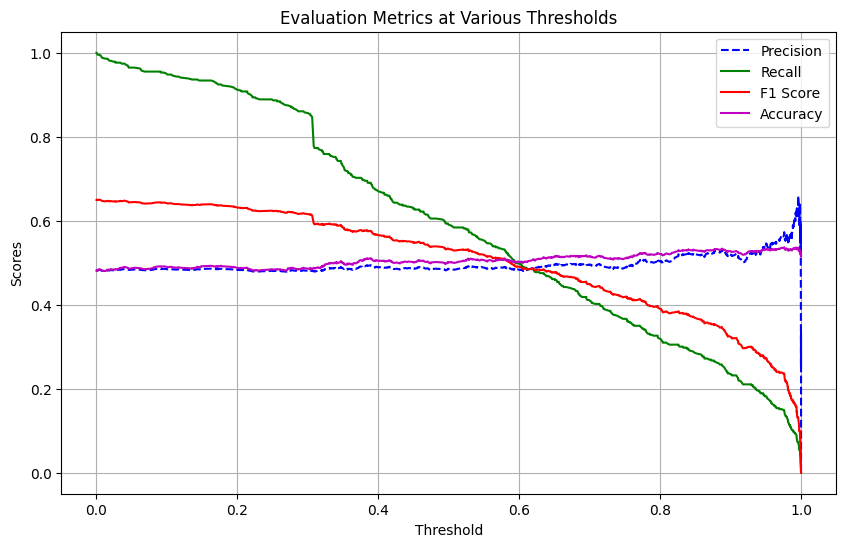

In [ ]:
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)

accuracies = []

# Calculate F1 scores and accuracy for each threshold
f1_scores = []
for threshold in thresholds:
    y_pred = (y_prob >= threshold).astype(int)
    f1_scores.append(f1_score(y_test, y_pred))
    accuracies.append(accuracy_score(y_test, y_pred))

# Plotting the precision, recall, F1-score, and accuracy as functions of the threshold
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precision[:-1], 'b--', label='Precision')
plt.plot(thresholds, recall[:-1], 'g-', label='Recall')
plt.plot(thresholds, f1_scores, 'r-', label='F1 Score')
plt.plot(thresholds, accuracies, 'm-', label='Accuracy')
plt.xlabel('Threshold')
plt.ylabel('Scores')
plt.title('Evaluation Metrics at Various Thresholds')
plt.legend(loc='best')
plt.grid(True)
plt.show()


In [ ]:

y_pred_binary = np.where(y_pred > 0.9, 1, 0)

# Print classification report

print('Classification Report:')
print(classification_report(y_test, y_pred_binary))

Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.80      0.64       456
           1       0.52      0.23      0.32       423

    accuracy                           0.53       879
   macro avg       0.52      0.52      0.48       879
weighted avg       0.52      0.53      0.49       879



In [ ]:
model = Sequential([
    LSTM(256, input_shape=(30, 1536), return_sequences=True, kernel_regularizer=l2(0.01)),
    Dropout(0.2),
    BatchNormalization(),

    LSTM(128, return_sequences=True, kernel_regularizer=l2(0.01)),
    Dropout(0.2),
    BatchNormalization(),

    LSTM(64, return_sequences=False, kernel_regularizer=l2(0.01)),
    Dropout(0.2),
    BatchNormalization(),

    Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.2),
    BatchNormalization(),

    Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),

    Dense(16, activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),

    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 30, 256)           1836032   
                                                                 
 dropout_4 (Dropout)         (None, 30, 256)           0         
                                                                 
 batch_normalization_6 (Bat  (None, 30, 256)           1024      
 chNormalization)                                                
                                                                 
 lstm_4 (LSTM)               (None, 30, 128)           197120    
                                                                 
 dropout_5 (Dropout)         (None, 30, 128)           0         
                                                                 
 batch_normalization_7 (Bat  (None, 30, 128)           512       
 chNormalization)                                     

In [ ]:
news_df = news_df.sort_values(by='Date')

In [ ]:
X = np.array([np.fromstring(record.strip('[]'), sep=',') for record in news_df['Concatenated_News_Embedding']])

y = np.array(news_df['1_day_return_positive'])

print(X.shape)

(8795, 1536)


In [ ]:
split_fraction = 0.8
split_index = int(X.shape[0] * split_fraction)

X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(7036, 1536)
(1759, 1536)
(7036,)
(1759,)


In [ ]:
from sklearn.preprocessing import StandardScaler

# Assuming X_train and X_test are your data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(7036, 1536)
(1759, 1536)
(7036,)
(1759,)


In [ ]:
def create_sequences(X, y, window_size):
    X_seqs = []
    y_labels = []
    for i in range(len(X) - window_size):
        X_seq = X[i:i + window_size]  # Create a window of features
        y_label = y[i + window_size]  # Get the label corresponding to the end of the window
        X_seqs.append(X_seq)
        y_labels.append(y_label)
    return np.array(X_seqs), np.array(y_labels)

In [ ]:
window_size = 30
X_train, y_train = create_sequences(X_train, y_train, window_size)
X_test, y_test = create_sequences(X_test, y_test, window_size)

In [ ]:
print("X_train shape:", X_train.shape)  # Should show 80% of your samples
print("X_test shape:", X_test.shape)   # Should show the remaining 20%
print("y_train shape:", y_train.shape) # Corresponding 80% labels
print("y_test shape:", y_test.shape)   # Remaining 20% labels

X_train shape: (7006, 30, 1536)
X_test shape: (1729, 30, 1536)
y_train shape: (7006,)
y_test shape: (1729,)


In [ ]:
history = model.fit(X_train, y_train, epochs=70, batch_size=100, validation_data=(X_test, y_test))

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Accuracy: {accuracy}')


Epoch 1/70
71/71 [==============================] - 19s 79ms/step - loss: 14.1307 - accuracy: 0.5363 - val_loss: 8.7936 - val_accuracy: 0.5176
Epoch 2/70
71/71 [==============================] - 3s 39ms/step - loss: 6.3880 - accuracy: 0.5629 - val_loss: 4.5175 - val_accuracy: 0.5113
Epoch 3/70
71/71 [==============================] - 2s 34ms/step - loss: 3.8085 - accuracy: 0.5628 - val_loss: 3.0302 - val_accuracy: 0.5078
Epoch 4/70
71/71 [==============================] - 2s 35ms/step - loss: 2.6896 - accuracy: 0.5507 - val_loss: 2.2568 - val_accuracy: 0.5188
Epoch 5/70
71/71 [==============================] - 2s 35ms/step - loss: 1.9564 - accuracy: 0.5608 - val_loss: 1.7393 - val_accuracy: 0.5084
Epoch 6/70
71/71 [==============================] - 3s 44ms/step - loss: 1.5467 - accuracy: 0.5671 - val_loss: 1.4143 - val_accuracy: 0.5142
Epoch 7/70
71/71 [==============================] - 3s 40ms/step - loss: 1.2707 - accuracy: 0.5709 - val_loss: 1.2155 - val_accuracy: 0.5095
Epoch 8/70


In [ ]:
y_prob = model.predict(X_test)

55/55 [==============================] - 2s 12ms/step


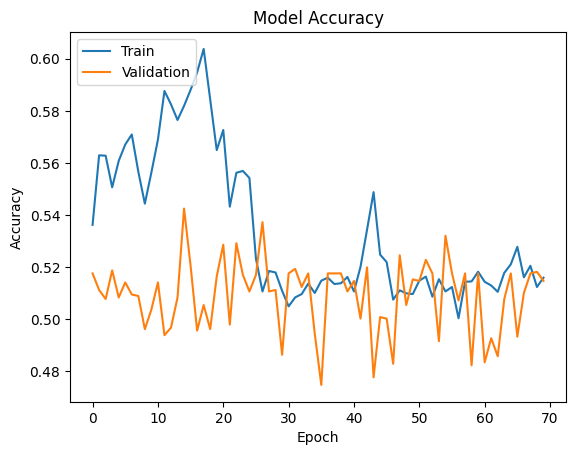

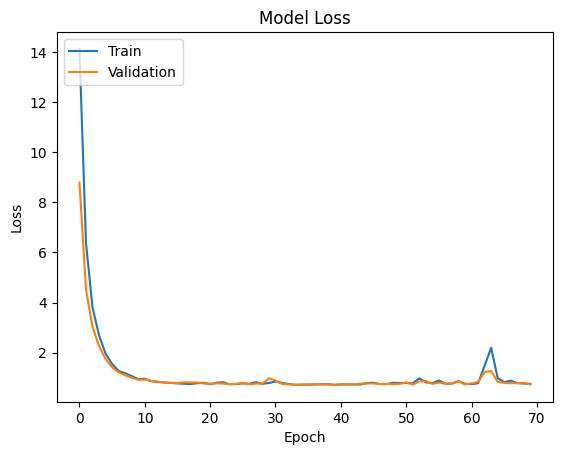

In [ ]:
# Summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

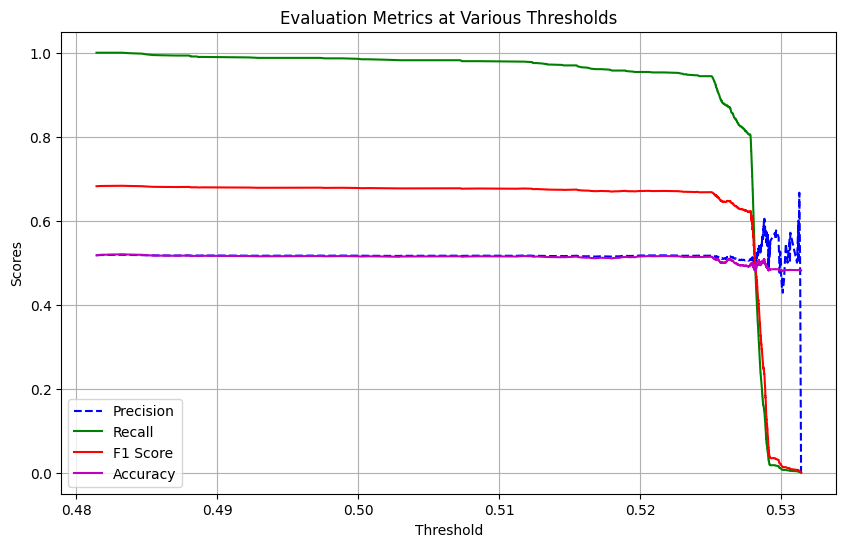

In [ ]:
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)

accuracies = []

# Calculate F1 scores and accuracy for each threshold
f1_scores = []
for threshold in thresholds:
    y_pred = (y_prob >= threshold).astype(int)
    f1_scores.append(f1_score(y_test, y_pred))
    accuracies.append(accuracy_score(y_test, y_pred))

# Plotting the precision, recall, F1-score, and accuracy as functions of the threshold
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precision[:-1], 'b--', label='Precision')
plt.plot(thresholds, recall[:-1], 'g-', label='Recall')
plt.plot(thresholds, f1_scores, 'r-', label='F1 Score')
plt.plot(thresholds, accuracies, 'm-', label='Accuracy')
plt.xlabel('Threshold')
plt.ylabel('Scores')
plt.title('Evaluation Metrics at Various Thresholds')
plt.legend(loc='best')
plt.grid(True)
plt.show()

In [ ]:
y_pred_binary = np.where(y_prob > 0.5, 1, 0)

# Print classification report

print('Classification Report:')
print(classification_report(y_test, y_pred_binary))

Classification Report:
              precision    recall  f1-score   support

           0       0.39      0.01      0.02       834
           1       0.52      0.98      0.68       895

    accuracy                           0.51      1729
   macro avg       0.45      0.50      0.35      1729
weighted avg       0.46      0.51      0.36      1729

